<a href="https://colab.research.google.com/github/GladiceLee/Shipping-Route-Cost-Optimization/blob/main/FAaRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Datas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def read_file(file_name):
    file = pd.ExcelFile(Supply_Chain_Logisitcs_Problem)
    dfs = {}
    for sheet in file.sheet_names:
        dfs[sheet] = file.parse(sheet)
    return dfs

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
dfs = read_file("Supply_Chain_Logisitcs_Problem")
for k, v in dfs.items():
    print(f'{k} {v.shape}:')
    print(str(dfs[k].columns.values))
    print('_' * 80)

NameError: name 'Supply_Chain_Logisitcs_Problem' is not defined

# Observe the data

##### Redudant columns
There's only `2013-05-26` in `dfs['OrderList']['Order Date']`\
There's only `PORT09` in `dfs['OrderList']['Destination Port']`\
There's only `PORT09` in `dfs['FreightRates']['dest_port_cd']`

In [ ]:
print('The columns that have only one unique value(redundant) are:')
print('_' * 80)
print(f'{"|Dataframe|":<20} {"|Column|":<20} {"|Value|"}')
for k, v in dfs.items():
    for c in v.columns:
        if v[c].nunique() == 1:
            print(f'{k:<20} {c:<20} {v[c].unique()[0]}')

The columns that have only one unique value(redundant) are:
________________________________________________________________________________
|Dataframe|          |Column|             |Value|
OrderList            Order Date           2013-05-26 00:00:00
OrderList            Destination Port     PORT09
FreightRates         dest_port_cd         PORT09


##### There's no `PORT01` in `dfs['FreightRates']['orig_port_cd']`

In [ ]:
print(sorted(dfs['FreightRates']['orig_port_cd'].unique()))

['PORT02', 'PORT03', 'PORT04', 'PORT05', 'PORT06', 'PORT07', 'PORT08', 'PORT09', 'PORT10', 'PORT11']


##### The Total Capacities is `5791`

In [ ]:
print(sum(b for a,b in dfs['WhCapacities'].values))

5791


##### The Total Combination of `('Customer', 'Product ID')` is `1684`

In [ ]:
print(len(dfs['OrderList']))
print(len(dfs['OrderList'][['Customer', 'Product ID']].value_counts()))

9215
1684


##### There exist some order, ship both ahead and late

In [ ]:
ship_ahead_index = dfs['OrderList']['Ship ahead day count'] > 0
ship_late_index = dfs['OrderList']['Ship Late Day count'] > 0
contradiction = dfs['OrderList'][ship_ahead_index & ship_late_index]
print(len(contradiction))


123


##### Carrier: V44_3 didn't exist in FreightRates

In [ ]:
# find all OrderList.Carriers that don't exist in FreightRates.Carrier
print(set(dfs['OrderList']['Carrier'].unique()))
print(set(dfs['FreightRates']['Carrier'].unique()))
print(set(dfs['OrderList']['Carrier'].unique()) - set(dfs['FreightRates']['Carrier'].unique()))

{'V444_0', 'V444_1', 'V44_3'}
{'V444_6', 'V444_0', 'V444_2', 'V444_4', 'V444_5', 'V444_9', 'V444_7', 'V444_8', 'V444_1'}
{'V44_3'}


##### Check if there's a product can produce by multiple plant

In [ ]:
print(dfs['ProductsPerPlant']['Product ID'].value_counts().value_counts())

count
1    1271
2     141
4      71
3      43
5      14
Name: count, dtype: int64


In [ ]:
print(dfs['VmiCustomers'])

   Plant Code                Customers
0     PLANT02        V5555555555555_16
1     PLANT02      V555555555555555_29
2     PLANT02             V555555555_3
3     PLANT02        V55555555555555_8
4     PLANT02              V55555555_9
5     PLANT02                V55555_10
6     PLANT02              V55555555_5
7     PLANT06      V555555555555555_18
8     PLANT06                V55555_10
9     PLANT10      V555555555555555_29
10    PLANT10               V555555_34
11    PLANT10  V5555555555555555555_54
12    PLANT10                V55555_10
13    PLANT11  V5555555555555555555_54


# Define the problem
Given ['Customer', 'Product ID', 'Unit quantity', 'Weight']\
return min cost with plant, port_for_plant, and frieght

##### Build a dataframe from product id to possible (port, plant) pair

In [ ]:
dfs['ProductsPort'] = pd.merge(dfs['ProductsPerPlant'], dfs['PlantPorts'], on='Plant Code')
# dfs['ProductsPort']['Plant-Port'] = list(zip(dfs['ProductsPort']['Plant Code'], dfs['ProductsPort']['Port']))
# dfs['ProductsPort'] = dfs['ProductsPort'].groupby('Product ID')['Plant-Port'].agg(list).reset_index()

## Easy version: find the result without the plant limit

In [ ]:
def product_cost(unit_quantity, plant_id):
    row_index = dfs['WhCosts']['WH'] == plant_id
    unit_price = dfs['WhCosts'][row_index]['Cost/unit'].values[0]
    return unit_quantity * unit_price


In [ ]:
def transport_cost(service_level, weight, frieghts):
    if service_level == 'CRF':
        return 0

    min_cost = np.inf
    for i in range(len(frieghts)):
        freight = frieghts.iloc[i]
        cost = max(freight['rate'] * weight, freight['minimum cost'])
        if cost < min_cost:
            min_cost = cost
    return min_cost

In [ ]:
def find_freights(orig_port, weight):
    target = (dfs['FreightRates']['orig_port_cd'] == orig_port) & \
            (dfs['FreightRates']['minm_wgh_qty'] <= weight) & \
            (dfs['FreightRates']['max_wgh_qty'] + 1 > weight)
    return dfs['FreightRates'][target]

In [ ]:
def min_cost_per_order(order):
    weight = order['Weight']
    unit_quantity = order['Unit quantity']
    product_id = order['Product ID']
    customer = order['Customer']
    service_level = order['Service Level']
    target_rows = dfs['ProductsPort']['Product ID'] == product_id

    order['ans_min_cost'] = np.inf
    order['ans_plant_id'] = None
    order['ans_port'] = None
    for row in dfs['ProductsPort'][target_rows].values:
        plant_id, _, port = row
        if (dfs['VmiCustomers']['Plant Code'] != plant_id).all() or\
            ((dfs['VmiCustomers']['Plant Code'] == plant_id) & (dfs['VmiCustomers']['Customers'] == customer)).any():

            cost_p = product_cost(unit_quantity, plant_id)
            frieghts = find_freights(port, weight)
            cost_t = transport_cost(service_level, weight, frieghts)
            if cost_p + cost_t < order['ans_min_cost']:
                order['ans_min_cost'] = cost_p + cost_t
                order['ans_plant_id'] = plant_id
                order['ans_port'] = port
    return order
dfs['newOrder'] = dfs['OrderList'].apply(min_cost_per_order, axis=1)

In [ ]:
selected_columns = ['Customer', 'Product ID', 'Unit quantity', 'Weight', 'Service Level', 'ans_min_cost', 'ans_plant_id', 'ans_port']
dfs['newOrder'] = dfs['newOrder'][selected_columns]

### Analysis

##### Plant Hist Count

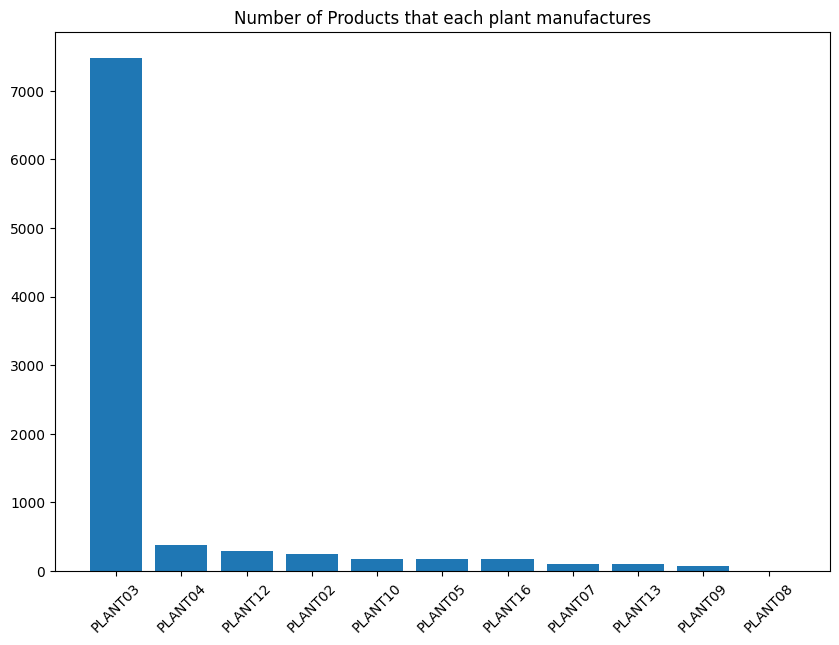

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
plt.xticks(rotation=45)
plant_counts = pd.DataFrame(dfs['newOrder']["ans_plant_id"].value_counts())
ax.bar(plant_counts.index, plant_counts["count"])
plt.title("Number of Products that each plant manufactures")
plt.show()


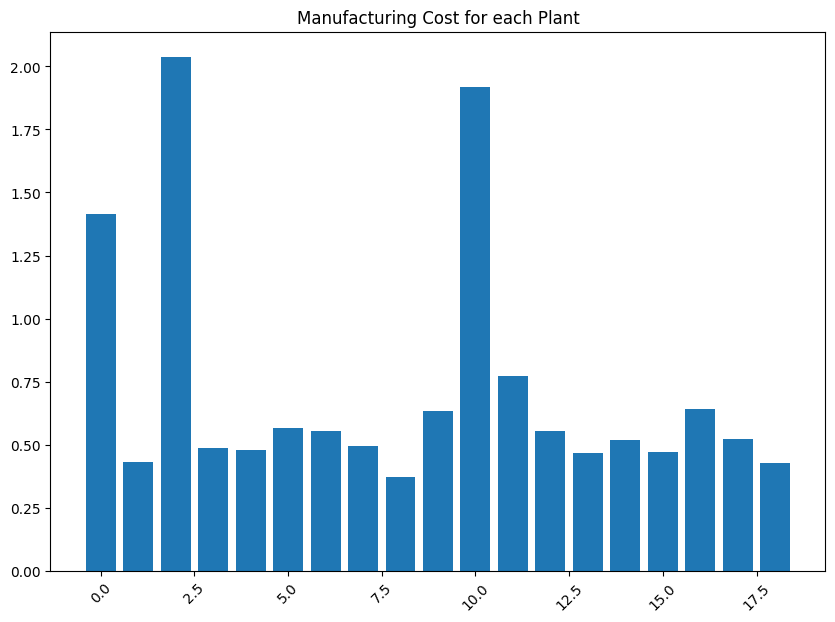

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
plt.xticks(rotation=45)
ax.bar(dfs['WhCosts'].index, dfs['WhCosts']["Cost/unit"])
plt.title("Manufacturing Cost for each Plant")
plt.show()

## Original Problem: consider the capacities